In [ ]:
# 2020.06.30
# LeNet5 structure run the face gender idendifaction task
# val accuracy: 0.9298

In [1]:
import numpy as np
import csv
import os
import keras
import sys
import cv2
from os.path import dirname
from os import getcwd
from keras.layers.convolutional import Convolution2D, MaxPooling2D
from keras.layers.core import Activation, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import np_utils
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from framework.util import get_gender_label, get_image_array, myStandardScaler, Generate_feature, MaxPooling

Using TensorFlow backend.


In [2]:
def flip_aug(x):
    new_x = []
    for i in range(len(x)):
        new_x.append(cv2.flip(x[i], 1).reshape(x.shape[1], x.shape[2], -1))
    return np.array(new_x)

def cwPCA(x, eng_percent):
    pca = PCA(n_components=500)
    x = pca.fit_transform(x)
    ratio = np.cumsum(pca.explained_variance_ratio_) >= eng_percent
    n_comp = np.argmax(ratio)
    #print(n_comp, " compontents retained!")
    x = x[:, :n_comp]
    dis = euclidean_distances(x, x)+1000*np.eye(len(x))
    return dis

def pca_aug(x, eng_percent=0.9):
    xx = x.copy()
    x = x.reshape(x.shape[0], -1, 3)/255
    dis0 = cwPCA(x[:,:,0], eng_percent)
    dis1 = cwPCA(x[:,:,1], eng_percent)
    dis2 = cwPCA(x[:,:,2], eng_percent)
    idx = np.argmin(dis0+dis1+dis2, axis=1)
    new_x = []
    ct = 1
    for i in range(len(xx)):
        tmp = xx[i]/2 + xx[idx[i]] / 2
        #tmp = cv2.equalizeHist(tmp.astype(np.uint8))
        new_x.append(tmp)
        if ct > 0:
            plt.imshow(tmp[:,:])
            plt.title('mean')
            plt.show()
            plt.imshow(xx[i,:,:])
            plt.title('raw')
            plt.show()
            ct -= 1
    return np.array(new_x).reshape(xx.shape[0], xx.shape[1], xx.shape[2], -1)

def data_aug(xf):
    print('before aug', xf.shape)
    x1 = flip_aug(xf)
    x2 = pca_aug(xf)
    xf = np.concatenate((xf, x1, x2), axis=0)
    print('after aug', xf.shape)
    return xf

(2357, 32, 32, 3)


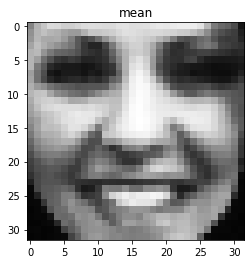

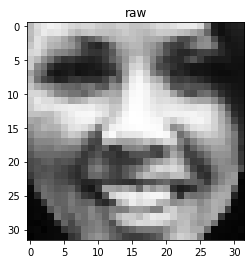

(2357, 32, 32, 3)
after aug (7071, 32, 32, 3)
(17559, 32, 32, 3) (2623, 32, 32, 3)


In [3]:
folder_path = dirname(getcwd())
lfwlabels = get_gender_label(folder_path)
lfw_raw = get_image_array(folder_path)
train_images, test_data, y, yt = train_test_split(lfw_raw, lfwlabels, test_size=0.2, stratify=lfwlabels)

x_aug = data_aug(train_images[y==0])
train_data = np.concatenate((train_images, x_aug), axis=0)
y = np.concatenate((y, np.zeros(len(x_aug))), axis=0)

train_labels = np_utils.to_categorical(y, 2)
test_labels = np_utils.to_categorical(yt, 2)
#train_data = train_data[:,:,:,0].reshape(train_data.shape[0], train_data.shape[1], train_data.shape[2],1)
#test_data = test_data[:,:,:,0].reshape(test_data.shape[0], test_data.shape[1], test_data.shape[2],1)
print(train_data.shape, test_data.shape)

In [4]:
def LeNet5():
    model = Sequential()
    model.add(Convolution2D(filters = 6, kernel_size = (5, 5), padding = "valid", input_shape = (32, 32, 3)))
    model.add(Activation(activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2, 2), strides =  (2, 2)))
    model.add(Convolution2D(filters = 16, kernel_size = (5, 5), padding = "valid"))
    model.add(Activation(activation = "relu"))
    model.add(MaxPooling2D(pool_size = (2, 2), strides = (2, 2)))
    model.add(Convolution2D(filters = 120, kernel_size = (5, 5), padding = "valid"))
    model.add(Flatten())
    model.add(Dense(120))
    model.add(Activation(activation = "relu"))
    model.add(Dense(84))
    model.add(Activation(activation = "relu"))
    model.add(Dense(2))
    model.add(Activation("softmax"))
    model.compile(loss = "categorical_crossentropy", optimizer = keras.optimizers.RMSprop(), metrics = ["accuracy"])
    return model
model = LeNet5()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         456       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 16)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 5, 5, 16)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 120)         48120     
__________

In [7]:
a, at = [], []
hist = []
nb_epoch = 50
for i in range(10):
    print('------',i)
    model = LeNet5()
    history = model.fit(train_data, train_labels, batch_size = 128, epochs = nb_epoch, verbose = 0, validation_data=(test_data, test_labels),shuffle=True)
    a.append(history.history['acc'])
    at.append(history.history['val_acc'])
    hist.append(history)
    

------ 0
------ 1
------ 2
------ 3
------ 4
------ 5
------ 6
------ 7
------ 8
------ 9


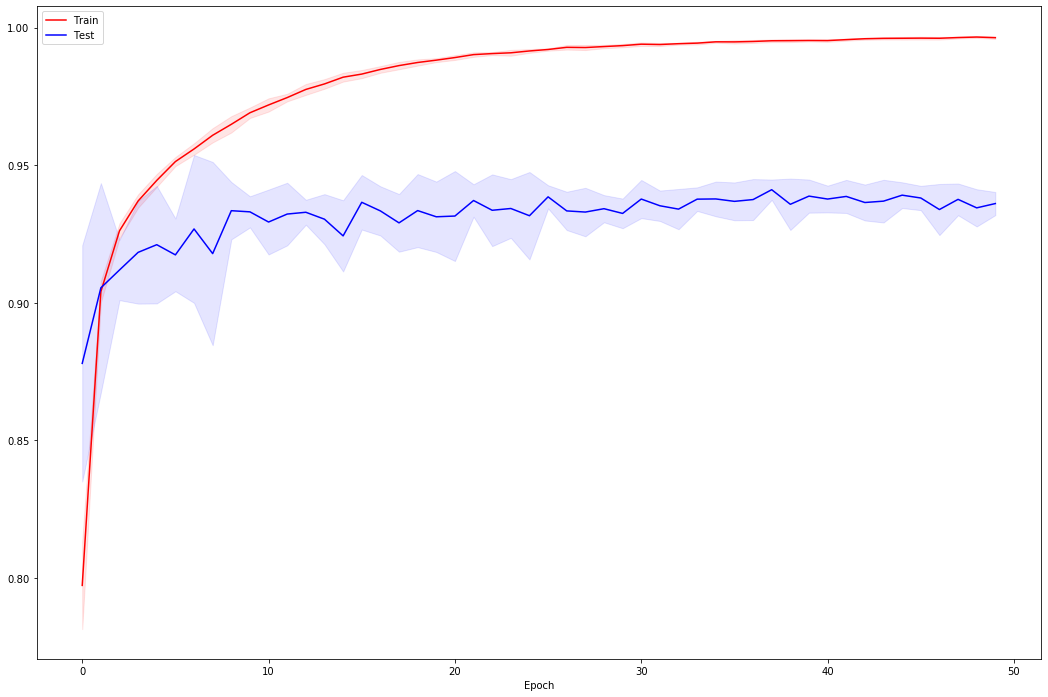

In [8]:
plt.figure(figsize=(18, 12))
plt.plot(np.arange(nb_epoch), np.mean(a, axis=0), color='r')
plt.fill_between(np.arange(nb_epoch), np.mean(a, axis=0)+np.std(a, axis=0), np.mean(a, axis=0)-np.std(a, axis=0), color='r', alpha=0.1)
plt.plot(np.arange(nb_epoch), np.mean(at, axis=0), color='b')
plt.fill_between(np.arange(nb_epoch), np.mean(at, axis=0)+np.std(at, axis=0), np.mean(at, axis=0)-np.std(at, axis=0), color='b', alpha=0.1)
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [13]:
(loss, accuracy) = model.evaluate(test_data, test_labels, batch_size = 128, verbose = 0)
print('loss:', loss, '\nval acc:', accuracy)

loss: 0.5109794195081003 
val acc: 0.9298513153560098
